# Library Imports & Loading Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [2]:
import networkx as nx

# load jaccard graph
try:
    G_jaccard = nx.read_gexf("../data/new_data_jaccard_network_with_all_attributes.gexf")
    print(f"\nJaccard graph loaded: {G_jaccard.number_of_nodes()} nodes.")
except FileNotFoundError:
    print("ERROR: Could not find 'new_data_jaccard_network_with_all_attributes.gexf'")
    raise

# load Spearman
try:
    G_spearman = nx.read_gexf("../data/new_data_spearman_network_with_all_attributes.gexf")
    print(f"Spearman graph loaded: {G_spearman.number_of_nodes()} nodes.")
except FileNotFoundError:
    print("ERROR: Could not find 'new_data_spearman_network_with_all_attributes.gexf'")
    raise

# load glasso
try:
    G_glasso_core = nx.read_gexf("../data/new_data_glasso_network_CORE_with_all_attributes.gexf")
    print(f"Glasso Core graph loaded: {G_glasso_core.number_of_nodes()} nodes.")
except FileNotFoundError:
    print("FATAL ERROR: Could not find 'new_data_glasso_network_CORE_with_all_attributes.gexf'")
    raise

# nodes in every 
jaccard_nodes = set(G_jaccard.nodes())
spearman_nodes = set(G_spearman.nodes())
glasso_nodes = set(G_glasso_core.nodes())

# overlap
overlap_jac_glasso = jaccard_nodes.intersection(glasso_nodes)
overlap_spear_glasso = spearman_nodes.intersection(glasso_nodes)
overlap_jac_spear = jaccard_nodes.intersection(spearman_nodes)
ultra_core = jaccard_nodes.intersection(spearman_nodes).intersection(glasso_nodes)

# results
print("-" * 30)
print(f"Overlap Jaccard & Glasso:  {len(overlap_jac_glasso)} nodes")
print(f"Overlap Spearman & Glasso: {len(overlap_spear_glasso)} nodes")
print(f"Overlap Jaccard & Spearman:{len(overlap_jac_spear)} nodes")
print("-" * 30)
print(f"ULTRA-CORE (common in all 3): {len(ultra_core)} nodes")
print("-" * 30)

if len(ultra_core) > 0:
    print("SUCCESS: Your refinement pipeline is consistent!")
else:
    print("WARNING: No common nodes found across all three. Check node ID formats.")


Jaccard graph loaded: 5201 nodes.
Spearman graph loaded: 637 nodes.
Glasso Core graph loaded: 440 nodes.
------------------------------
Overlap Jaccard & Glasso:  330 nodes
Overlap Spearman & Glasso: 334 nodes
Overlap Jaccard & Spearman:595 nodes
------------------------------
ULTRA-CORE (common in all 3): 316 nodes
------------------------------
SUCCESS: Your refinement pipeline is consistent!


# Hub Comparison & Cluster vs Cluster

In [3]:
# Hub comparison (Simplified)

METRIC_TO_COMPARE = 'betweenness_score' 

# get Top 10 Hubs (Jaccard)
jaccard_scores = pd.Series(nx.get_node_attributes(G_jaccard, METRIC_TO_COMPARE))
jaccard_top10 = set(jaccard_scores.nlargest(10).index)

# get Top 10 Hubs (Glasso)
glasso_scores = pd.Series(nx.get_node_attributes(G_glasso_core, METRIC_TO_COMPARE))
glasso_top10 = set(glasso_scores.nlargest(10).index)

# compare the lists
print(f"\nTop 10 Hubs based on {METRIC_TO_COMPARE}")
print(f"\nJaccard Top 10 Hubs:{jaccard_top10}")
print(f"\nGlasso Core Top 10 Hubs:{glasso_top10}")

overlap = jaccard_top10.intersection(glasso_top10)
print(f"\nNumber of hubs in BOTH Top 10 lists: {len(overlap)}")
print(f"\nOverlapping 'Super-Hubs': {overlap}")


Top 10 Hubs based on betweenness_score

Jaccard Top 10 Hubs:{'GCF_ae5058c7b3', 'GCF_d41e2ed479', 'GCF_ceb8e5a21b', 'GCF_17ea62e730', 'GCF_45129e2542', 'GCF_fed52c71ea', 'GCF_306abe7dd8', 'GCF_71a5e1a76e', 'GCF_1d0c9bca2c', 'GCF_ab134eac7a'}

Glasso Core Top 10 Hubs:{'GCF_c007ec0dcc', 'GCF_3bf7c2fc79', 'GCF_32a52f3443', 'GCF_0970e9a3e2', 'GCF_0f8a262ffa', 'GCF_3d3b9d6d75', 'GCF_fbe378499e', 'GCF_e468c5d75d', 'GCF_ba98f56db5', 'GCF_8c7b546f7e'}

Number of hubs in BOTH Top 10 lists: 0

Overlapping 'Super-Hubs': set()


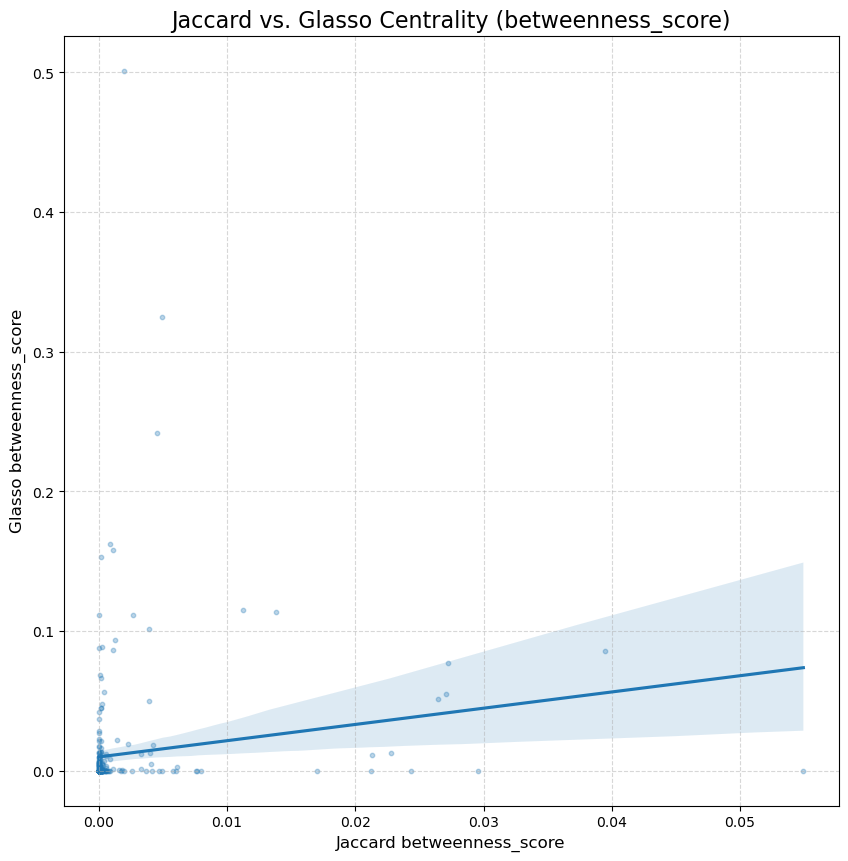

Spearman Correlation: 0.4117


In [4]:
# Centrality Scatter Plot

# get ALL scores from both graphs
jaccard_scores_all = pd.Series(nx.get_node_attributes(G_jaccard, METRIC_TO_COMPARE))
glasso_scores_all = pd.Series(nx.get_node_attributes(G_glasso_core, METRIC_TO_COMPARE))

# combine into a single DataFrame
df_scatter = pd.DataFrame({
    'jaccard_centrality': jaccard_scores_all,
    'glasso_centrality': glasso_scores_all
})

# .dropna() only uses nodes that are in both networks
df_scatter = df_scatter.dropna()

# create scatter plot
plt.figure(figsize=(10, 10))

# 'regplot'
sns.regplot(
    data=df_scatter,
    x='jaccard_centrality',
    y='glasso_centrality',
    scatter_kws={'alpha':0.3, 's':10} # Make points small and transparent
)

plt.title(f'Jaccard vs. Glasso Centrality ({METRIC_TO_COMPARE})', fontsize=16)
plt.xlabel(f'Jaccard {METRIC_TO_COMPARE}', fontsize=12)
plt.ylabel(f'Glasso {METRIC_TO_COMPARE}', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# calculate correlation score
correlation = df_scatter['jaccard_centrality'].corr(df_scatter['glasso_centrality'], method='spearman')
print(f"Spearman Correlation: {correlation:.4f}")

In [5]:
# Cluster-vs-Cluster (Jaccard vs. Glasso)

# find the common nodes
jaccard_nodes = set(G_jaccard.nodes())
glasso_nodes = set(G_glasso_core.nodes())
common_nodes = jaccard_nodes.intersection(glasso_nodes)
print(f"Found {len(common_nodes)} nodes that are present in BOTH core networks.")

# create a comparison DataFrame
df_compare = pd.DataFrame(index=list(common_nodes))
df_compare['jaccard_community'] = pd.Series(nx.get_node_attributes(G_jaccard, 'community'))
df_compare['glasso_community'] = pd.Series(nx.get_node_attributes(G_glasso_core, 'community'))

# Drop any nodes that might be missing a community in one of the graphs
df_compare = df_compare.dropna()
print(f"Comparing {len(df_compare)} nodes with valid community data in both networks.")

# create the Community-vs-Community Crosstab
community_crosstab = pd.crosstab(df_compare['jaccard_community'], df_compare['glasso_community'])

# Get the Top 10 largest communities from each network
jaccard_top10 = df_compare['jaccard_community'].value_counts().nlargest(10).index
glasso_top10 = df_compare['glasso_community'].value_counts().nlargest(10).index

# Filter the crosstab to show only the Top 10 vs. Top 10
try:
    final_table = community_crosstab.loc[jaccard_top10, glasso_top10]
    # Filter out empty columns/rows just in case
    final_table = final_table.loc[(final_table > 0).any(axis=1), (final_table > 0).any(axis=0)]
    print(final_table.to_string())
except KeyError:
    print("Error: Some top communities were not found in the final comparison.")
    print("Showing the full (unfiltered) table instead:")
    print(community_crosstab.to_string())

Found 330 nodes that are present in BOTH core networks.
Comparing 330 nodes with valid community data in both networks.
glasso_community   Community_3  Community_2  Community_5  Community_1  Community_6  Community_8  Community_4  Community_9  Community_11  Community_7
jaccard_community                                                                                                                                   
Community_1                 32            0           26           20            0            0            0           18            15            0
Community_24                 0           21            0            2            0            0           15            0             0           11
Community_3                  0            0            0            2           23            0            0            0             0            0
Community_16                 0            0            0            0            0           22            0            0             0

Validation 334 based on glasso and spearman


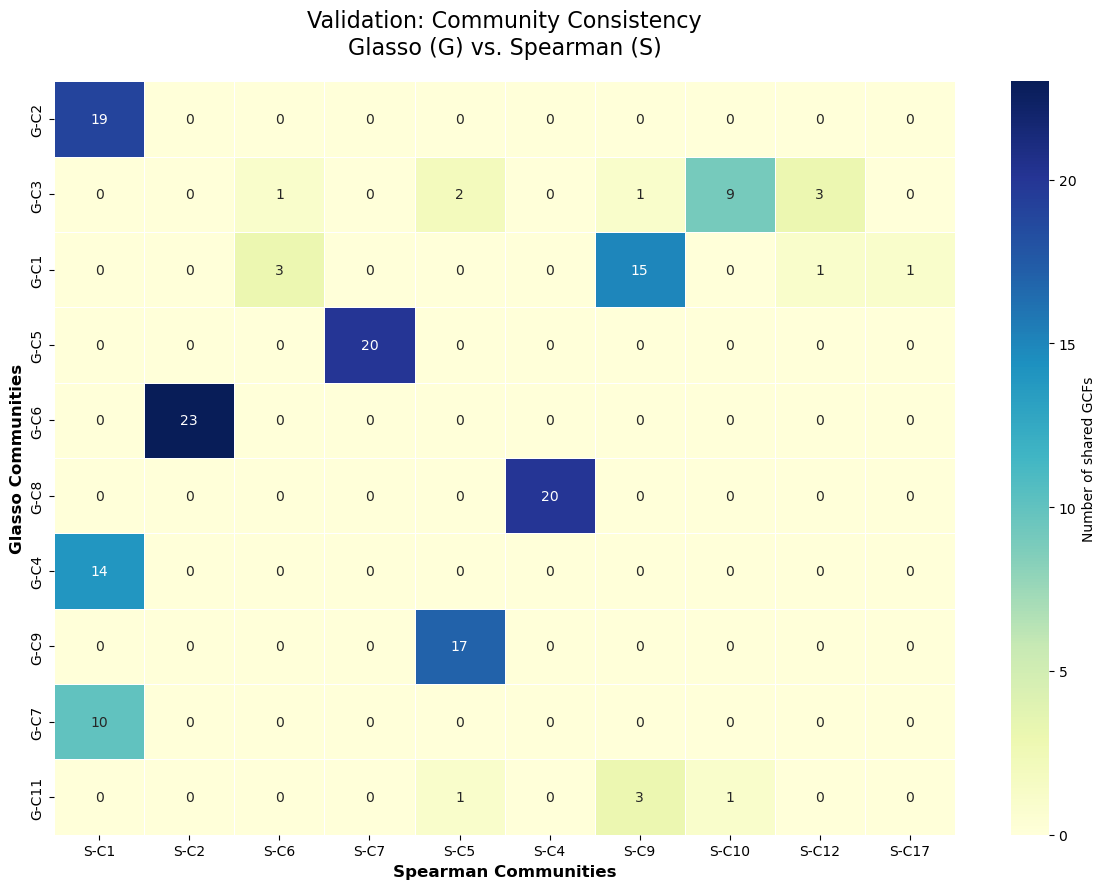

In [6]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# load networks
G_spearman = nx.read_gexf("../data/new_data_spearman_network_with_all_attributes.gexf")
G_glasso_core = nx.read_gexf("../data/new_data_glasso_network_CORE_with_all_attributes.gexf")

shared_nodes = set(G_spearman.nodes()) & set(G_glasso_core.nodes())
print(f"Validation {len(shared_nodes)} based on glasso and spearman")


df_compare = pd.DataFrame(index=list(shared_nodes))
df_compare['spearman_comm'] = pd.Series(nx.get_node_attributes(G_spearman, 'community'))
df_compare['glasso_comm'] = pd.Series(nx.get_node_attributes(G_glasso_core, 'community'))
df_compare = df_compare.dropna()

# create matrix
top_glasso_ids = df_compare['glasso_comm'].value_counts().nlargest(10).index
top_spearman_ids = df_compare['spearman_comm'].value_counts().nlargest(10).index

ct = pd.crosstab(df_compare['glasso_comm'], df_compare['spearman_comm'])
comparison_matrix = ct.loc[top_glasso_ids, top_spearman_ids]


comparison_matrix.index = [f"G-{str(i).replace('Community_', 'C')}" for i in comparison_matrix.index]
comparison_matrix.columns = [f"S-{str(i).replace('Community_', 'C')}" for i in comparison_matrix.columns]

#plotting
plt.figure(figsize=(12, 9))
sns.heatmap(comparison_matrix, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5,
            cbar_kws={'label': 'Number of shared GCFs'})

plt.title('Validation: Community Consistency\nGlasso (G) vs. Spearman (S)', fontsize=16, pad=20)
plt.xlabel('Spearman Communities', fontsize=12, fontweight='bold')
plt.ylabel('Glasso Communities', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
# Calculation of Heatmap Node Coverage

# 1. Get the list of IDs for the Top 10 communities in the shared pool
top_glasso_ids = df_compare['glasso_comm'].value_counts().nlargest(10).index
top_spearman_ids = df_compare['spearman_comm'].value_counts().nlargest(10).index

# 2. Filter the shared nodes to find only those present in BOTH Top 10s
# This identifies the specific GCFs that actually appear in the heatmap cells
nodes_in_heatmap_df = df_compare[
    (df_compare['glasso_comm'].isin(top_glasso_ids)) & 
    (df_compare['spearman_comm'].isin(top_spearman_ids))
]

# 3. Final Numbers
total_shared = len(df_compare)
count_heatmap = len(nodes_in_heatmap_df)
percentage = (count_heatmap / total_shared) * 100

print(f"--- Coverage Results ---")
print(f"Total Shared Nodes (Spearman & Glasso): {total_shared}")
print(f"Nodes captured in the 10x10 Heatmap:    {count_heatmap}")
print(f"Coverage Percentage:                    {percentage:.2f}%")

--- Coverage Results ---
Total Shared Nodes (Spearman & Glasso): 334
Nodes captured in the 10x10 Heatmap:    164
Coverage Percentage:                    49.10%


In [8]:
# 1. Get counts to see WHY certain IDs are chosen
glasso_counts = df_compare['glasso_comm'].value_counts()
spearman_counts = df_compare['spearman_comm'].value_counts()

print("--- Top Glasso Communities (within the 334 shared nodes) ---")
print(glasso_counts.head(12)) # Shows top 12 so you can see where C10 landed!

# 2. Fix the order for the Heatmap
# nlargest(10).index gives the IDs sorted by size (biggest first)
top_glasso_ids = glasso_counts.nlargest(10).index
top_spearman_ids = spearman_counts.nlargest(10).index

# Create the matrix and EXPLICITLY reindex it to keep the "Large to Small" order
ct = pd.crosstab(df_compare['glasso_comm'], df_compare['spearman_comm'])
comparison_matrix = ct.loc[top_glasso_ids, top_spearman_ids]

# 3. Labeling with Rank AND ID (for maximum clarity)
# This shows both: the Rank (1-10) and the original ID (like C11)
comparison_matrix.index = [f"G-Rank{i+1} ({str(idx).replace('Community_', 'C')})" 
                           for i, idx in enumerate(top_glasso_ids)]
comparison_matrix.columns = [f"S-Rank{i+1} ({str(idx).replace('Community_', 'C')})" 
                             for i, idx in enumerate(top_spearman_ids)]

--- Top Glasso Communities (within the 334 shared nodes) ---
glasso_comm
Community_2     33
Community_3     33
Community_1     28
Community_5     25
Community_6     23
Community_8     23
Community_4     22
Community_9     19
Community_7     15
Community_11    15
Community_13    11
Community_17    10
Name: count, dtype: int64


In [9]:
# --- Node Loss Analysis ---

# 1. The Base: Nodes present in both Spearman AND Glasso
nodes_sg = set(G_spearman.nodes()) & set(G_glasso_core.nodes())

# 2. The Intersection: Nodes present in all THREE (including Jaccard)
nodes_sgj = nodes_sg & set(G_jaccard.nodes())

# 3. Calculations
total_sg = len(nodes_sg)
total_sgj = len(nodes_sgj)
dropped = total_sg - total_sgj
percent_dropped = (dropped / total_sg) * 100 if total_sg > 0 else 0

print("--- Node Loss Check ---")
print(f"Nodes in Spearman & Glasso:          {total_sg}")
print(f"Nodes in all three (incl. Jaccard):   {total_sgj}")
print(f"Dropped due to Jaccard:               {dropped} ({percent_dropped:.2f}%)")

if percent_dropped > 20:
    print("\nRecommendation: Exclude Jaccard. The loss is too high for a robust heatmap.")
else:
    print("\nRecommendation: Jaccard can be included; the core is stable.")

--- Node Loss Check ---
Nodes in Spearman & Glasso:          334
Nodes in all three (incl. Jaccard):   316
Dropped due to Jaccard:               18 (5.39%)

Recommendation: Jaccard can be included; the core is stable.


# Comparative Analysis of Cluster Specificity

In [10]:
# HELPER FUNCTION: Specificity Boxplot (No 'Other')

def plot_cluster_specificity(G, attribute_name, label_name, network_name, min_size=4, top_n=15):
    """
    Creates a boxplot for cluster specificity (purity).
    Automatically filters out 'Other' to show only true categories.
    """

    # Fetch data
    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])
    
    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" SKIPPED {network_name}: Attribute '{attribute_name}' missing.")
        return

    # Clean category names (Sort: {A,B} == {B,A})
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.strip('{}')
            parts = sorted(content.split(','))
            return "{" + ",".join(parts) + "}"
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # Purity Calculation
    true_community_sizes = df['community'].value_counts()
    contingency_table = pd.crosstab(df['community'], df[attribute_name])
    
    communities_to_keep = true_community_sizes[true_community_sizes >= min_size].index
    filtered_contingency = contingency_table.reindex(communities_to_keep).fillna(0).astype(int)
    
    # Calculate percentages
    community_purity_percent = filtered_contingency.div(filtered_contingency.sum(axis=1), axis=0) * 100
    
    # remove "Other"
    # no "Other" in the boxplot as it is not a biological category
    cols_to_drop = [c for c in community_purity_percent.columns if 'other' in str(c).lower()]
    if cols_to_drop:
        community_purity_percent = community_purity_percent.drop(columns=cols_to_drop)

    if community_purity_percent.empty:
        print(f"No data left to plot for {network_name} (only 'Other' found).")
        return

    #  Prepare data for plotting
    purity_scores = community_purity_percent.max(axis=1)
    dominant_items = community_purity_percent.idxmax(axis=1)
    
    df_plot = pd.DataFrame({
        'Specificity (%)': purity_scores,
        'Dominant Item': dominant_items
    })
    
    # Filter: Show only the most frequent categories (Top N)
    top_items = df_plot['Dominant Item'].value_counts().nlargest(top_n).index
    df_plot = df_plot[df_plot['Dominant Item'].isin(top_items)]

    if df_plot.empty:
        print("No categories in Top N.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Boxplot
    sns.boxplot(data=df_plot, x='Dominant Item', y='Specificity (%)', color='steelblue', showfliers=False)
    
    # Stripplot (Points)
    sns.stripplot(data=df_plot, x='Dominant Item', y='Specificity (%)', color='black', size=5, alpha=0.6)
    
    plt.title(f'{network_name}: Cluster Specificity by {label_name}', fontsize=16)
    plt.xlabel(f'Dominant {label_name}', fontsize=12)
    plt.ylabel('Specificity (Purity %)', fontsize=12)
    plt.ylim(0, 105)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

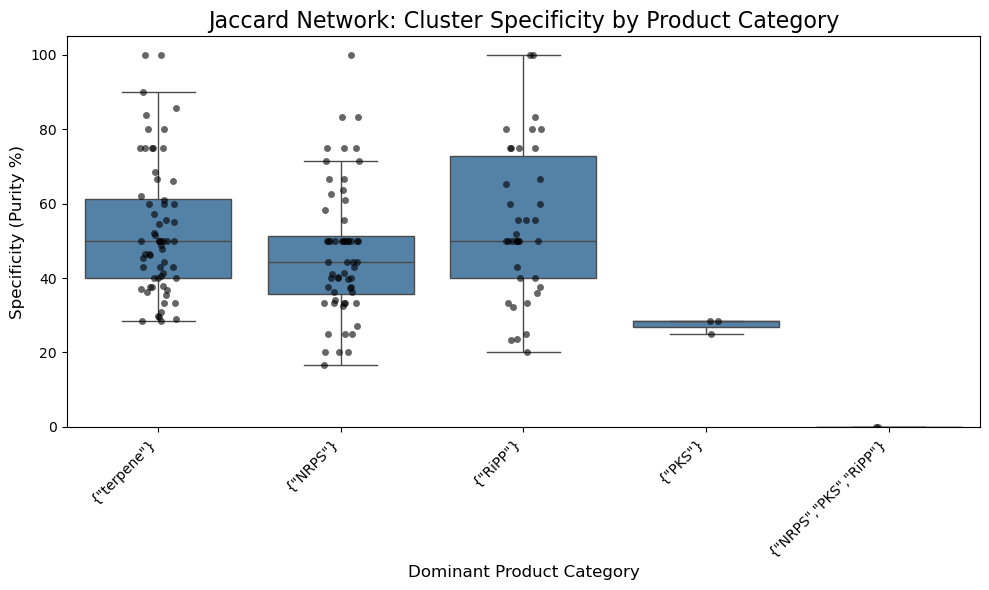

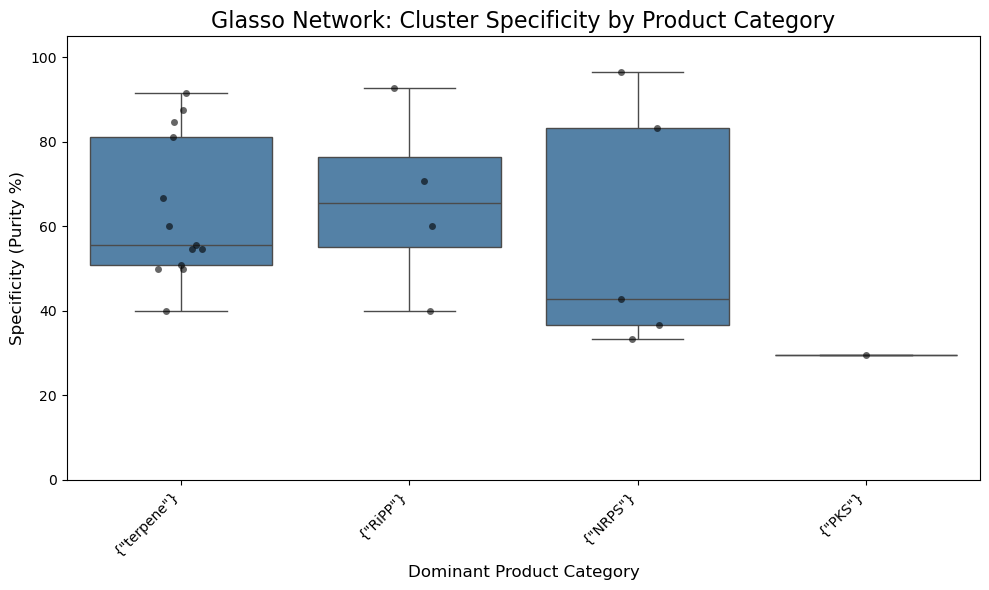

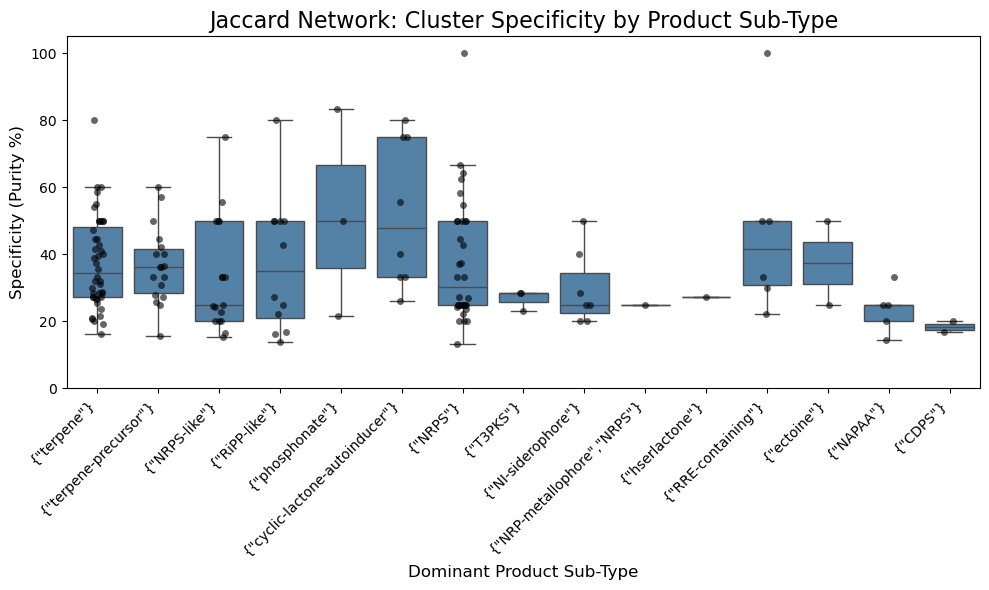

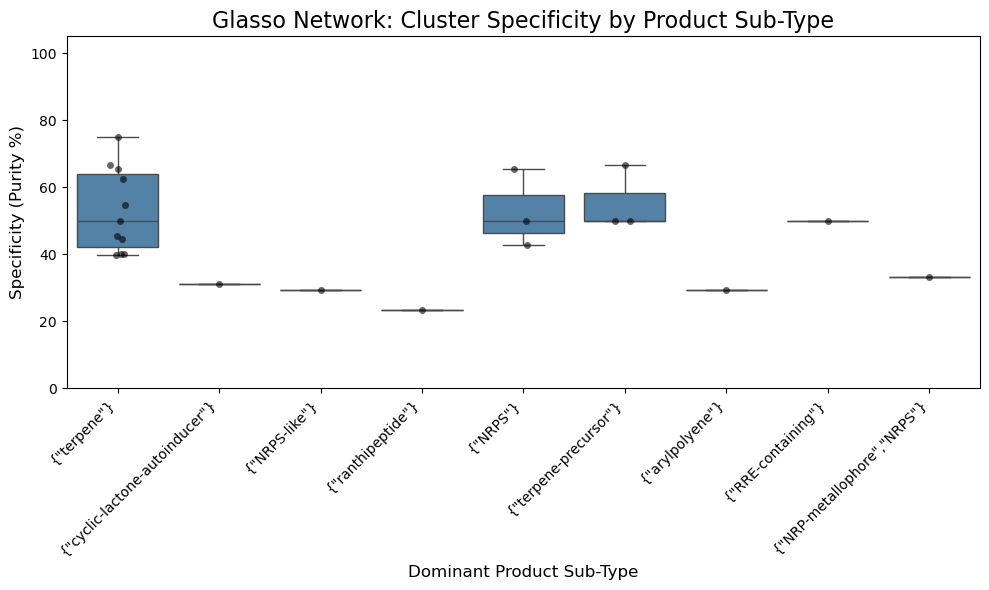

In [11]:
# RUN BOXPLOT ANALYSES

# # BIOME
# plot_cluster_specificity(G_jaccard, 'dominant_biome', 'Biome', "Jaccard Network", top_n=10)
# plot_cluster_specificity(G_glasso_core, 'dominant_biome', 'Biome', "Glasso Network", top_n=10, min_size=3)

# PRODUCT CATEGORIES
plot_cluster_specificity(G_jaccard, 'product_categories', 'Product Category', "Jaccard Network", top_n=10)
plot_cluster_specificity(G_glasso_core, 'product_categories', 'Product Category', "Glasso Network", top_n=10, min_size=3)

# SUB-CATEGORIES
plot_cluster_specificity(G_jaccard, 'product_subcategory', 'Product Sub-Type', "Jaccard Network", top_n=15)
plot_cluster_specificity(G_glasso_core, 'product_subcategory', 'Product Sub-Type', "Glasso Network", top_n=15, min_size=3)

# # 3. TAXONOMY (Genus)
# plot_cluster_specificity(G_jaccard, 'genus_id', 'Genus', "Jaccard Network", top_n=15)
# plot_cluster_specificity(G_glasso_core, 'genus_id', 'Genus', "Glasso Network", top_n=15, min_size=3)

# # 3. TAXONOMY (Species)
# plot_cluster_specificity(G_jaccard, 'species_id', 'Species', "Jaccard Network", top_n=15)
# plot_cluster_specificity(G_glasso_core, 'species_id', 'Species', "Glasso Network", top_n=15, min_size=3)

# # 3. TAXONOMY (Genus)
# plot_cluster_specificity(G_jaccard, 'family_id', 'Family', "Jaccard Network", top_n=15)
# plot_cluster_specificity(G_glasso_core, 'family_id', 'Family', "Glasso Network", top_n=15, min_size=3)